In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from torch import nn
import torchinfo
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms

from torchlake.common.controller.recorder import TrainRecorder
from torchlake.representation.controllers.trainer_dae import DenoisingAutoEncoderTrainer
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.random import generate_normal
from torchlake.representation.models.ae import AutoEncoder

# Setting

In [2]:
IMAGE_SIZE = 32
BATCH_SIZE = 128

In [3]:
artifact_path = Path("../../artifacts/dae")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/mnist")

In [4]:
DEVICE = torch.device("cuda:0")

# Data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        # lambda x: 2 * x - 1,
    ]
)

In [6]:
train_data = torchvision.datasets.MNIST(
    root=data_path.as_posix(),
    train=True,
    transform=preprocess,
    download=True,
)

test_data = torchvision.datasets.MNIST(
    root=data_path.as_posix(),
    train=False,
    transform=preprocess,
    download=True,
)

In [7]:
def collate_fn(batch):
    x, y = [], []
    
    for row in batch:
        x.append(row[0])
        y.append(row[1])

    return torch.stack(x), torch.Tensor(y), generate_normal((len(batch), 1, IMAGE_SIZE, IMAGE_SIZE), mu=0, sd=0.1)  

In [8]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    collate_fn=collate_fn,
)

test_loader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False,
)

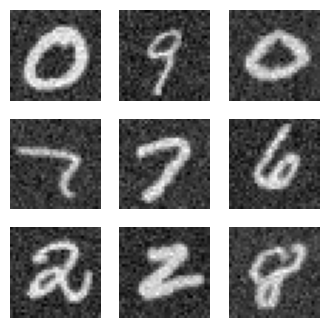

In [9]:
for x, _, z in train_loader:
    plot_grids(
        img_tensor_to_np((x+z)[:9]),
        num_row=3,
        num_col=3,
        cmap="gray",
        figsize=(4, 4),
    )
    break

# model

In [10]:
LATENT_DIM = 128

In [11]:
model = AutoEncoder(
    IMAGE_SIZE * IMAGE_SIZE,
    LATENT_DIM,
).to(DEVICE)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
AutoEncoder                              --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       131,200
│    └─Sigmoid: 2-2                      --
├─Sequential: 1-2                        --
│    └─Linear: 2-3                       132,096
Total params: 263,296
Trainable params: 263,296
Non-trainable params: 0

# train

In [13]:
EPOCH = 30

In [14]:
trainer = DenoisingAutoEncoderTrainer(EPOCH, DEVICE)

In [15]:
recorder = TrainRecorder(total_epoch=EPOCH)
recorder.increment_data_size(len(train_data))

In [16]:
LR = 1e-3

In [17]:
criterion = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model.parameters(), lr=LR)

In [18]:
_ = trainer.run(
    train_loader,
    model,
    optim,
    criterion,
    recorder=recorder,
)

Enable AMP: False
Training...


100%|██████████| 468/468 [00:15<00:00, 30.86it/s]


------------------------------------
Epoch 1
------------------------------------
total: 2.0127e-03 (0.00%)


100%|██████████| 468/468 [00:16<00:00, 28.54it/s]


------------------------------------
Epoch 2
------------------------------------
total: 1.5172e-03 (-25.00%)


100%|██████████| 468/468 [00:14<00:00, 31.35it/s]


------------------------------------
Epoch 3
------------------------------------
total: 1.3016e-03 (-14.00%)


100%|██████████| 468/468 [00:18<00:00, 24.64it/s]


------------------------------------
Epoch 4
------------------------------------
total: 1.1759e-03 (-10.00%)


100%|██████████| 468/468 [00:16<00:00, 28.22it/s]


------------------------------------
Epoch 5
------------------------------------
total: 1.0890e-03 (-7.00%)


100%|██████████| 468/468 [00:15<00:00, 30.23it/s]


------------------------------------
Epoch 6
------------------------------------
total: 1.0281e-03 (-6.00%)


100%|██████████| 468/468 [00:16<00:00, 28.87it/s]


------------------------------------
Epoch 7
------------------------------------
total: 9.8619e-04 (-4.00%)


100%|██████████| 468/468 [00:16<00:00, 27.72it/s]


------------------------------------
Epoch 8
------------------------------------
total: 9.5704e-04 (-3.00%)


100%|██████████| 468/468 [00:16<00:00, 28.61it/s]


------------------------------------
Epoch 9
------------------------------------
total: 9.3575e-04 (-2.00%)


100%|██████████| 468/468 [00:17<00:00, 27.23it/s]


------------------------------------
Epoch 10
------------------------------------
total: 9.1933e-04 (-2.00%)


100%|██████████| 468/468 [00:17<00:00, 27.25it/s]


------------------------------------
Epoch 11
------------------------------------
total: 9.0611e-04 (-1.00%)


100%|██████████| 468/468 [00:16<00:00, 28.37it/s]


------------------------------------
Epoch 12
------------------------------------
total: 8.9536e-04 (-1.00%)


100%|██████████| 468/468 [00:15<00:00, 29.74it/s]


------------------------------------
Epoch 13
------------------------------------
total: 8.8629e-04 (-1.00%)


100%|██████████| 468/468 [00:14<00:00, 32.69it/s]


------------------------------------
Epoch 14
------------------------------------
total: 8.7806e-04 (-1.00%)


100%|██████████| 468/468 [00:14<00:00, 32.79it/s]


------------------------------------
Epoch 15
------------------------------------
total: 8.7021e-04 (-1.00%)


100%|██████████| 468/468 [00:14<00:00, 32.90it/s]


------------------------------------
Epoch 16
------------------------------------
total: 8.6223e-04 (-1.00%)


100%|██████████| 468/468 [00:14<00:00, 33.15it/s]


------------------------------------
Epoch 17
------------------------------------
total: 8.5396e-04 (-1.00%)


100%|██████████| 468/468 [00:14<00:00, 33.11it/s]


------------------------------------
Epoch 18
------------------------------------
total: 8.4612e-04 (-1.00%)


100%|██████████| 468/468 [00:14<00:00, 33.19it/s]


------------------------------------
Epoch 19
------------------------------------
total: 8.3916e-04 (-1.00%)


100%|██████████| 468/468 [00:14<00:00, 33.12it/s]


------------------------------------
Epoch 20
------------------------------------
total: 8.3328e-04 (-1.00%)


100%|██████████| 468/468 [00:14<00:00, 33.20it/s]


------------------------------------
Epoch 21
------------------------------------
total: 8.2861e-04 (-1.00%)


100%|██████████| 468/468 [00:14<00:00, 33.21it/s]


------------------------------------
Epoch 22
------------------------------------
total: 8.2463e-04 (0.00%)


100%|██████████| 468/468 [00:14<00:00, 33.05it/s]


------------------------------------
Epoch 23
------------------------------------
total: 8.2130e-04 (0.00%)


100%|██████████| 468/468 [00:14<00:00, 32.92it/s]


------------------------------------
Epoch 24
------------------------------------
total: 8.1869e-04 (0.00%)


100%|██████████| 468/468 [00:14<00:00, 33.02it/s]


------------------------------------
Epoch 25
------------------------------------
total: 8.1650e-04 (0.00%)


100%|██████████| 468/468 [00:14<00:00, 32.01it/s]


------------------------------------
Epoch 26
------------------------------------
total: 8.1473e-04 (0.00%)


100%|██████████| 468/468 [00:14<00:00, 31.26it/s]


------------------------------------
Epoch 27
------------------------------------
total: 8.1312e-04 (0.00%)


100%|██████████| 468/468 [00:15<00:00, 30.80it/s]


------------------------------------
Epoch 28
------------------------------------
total: 8.1188e-04 (0.00%)


100%|██████████| 468/468 [00:16<00:00, 27.94it/s]


------------------------------------
Epoch 29
------------------------------------
total: 8.1066e-04 (0.00%)


100%|██████████| 468/468 [00:31<00:00, 14.90it/s]

------------------------------------
Epoch 30
------------------------------------
total: 8.0967e-04 (0.00%)


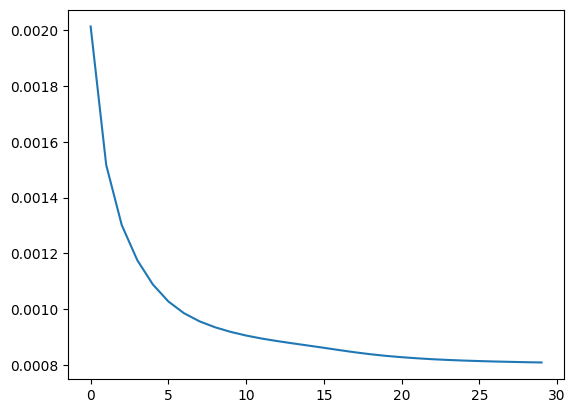

In [19]:
plt.plot(recorder.training_losses[0])

# evaluation

In [20]:
TEST_BATCH_SIZE = 8

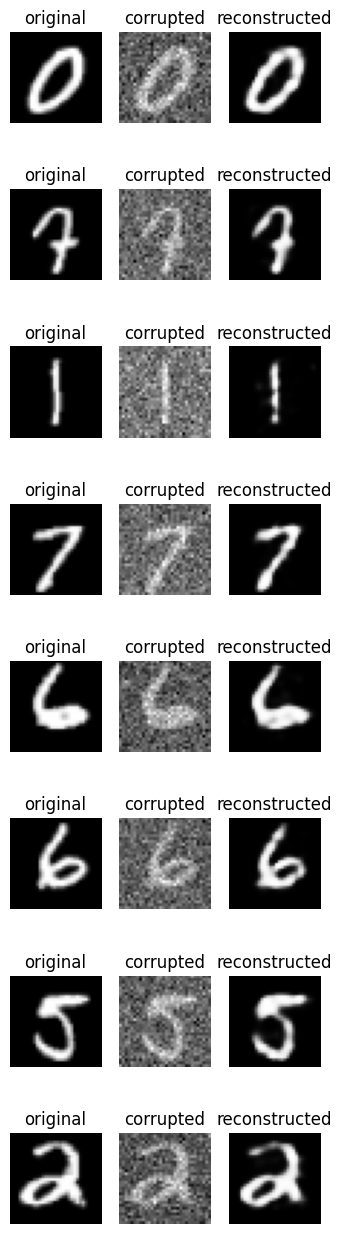

In [27]:
model.eval()
with torch.no_grad():
    x, y = next(iter(test_loader))
    x = x.to(DEVICE)
    noise = generate_normal((BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE), mu=0, sd=0.3).to(DEVICE)
    xhat, z = model(x+noise, output_latent=True)
    xhat= xhat.sigmoid()

plot_grids(
    img_tensor_to_np(torch.stack((x, x+noise, xhat), 1)[:TEST_BATCH_SIZE].flatten(0, 1)),
    ("original", "corrupted", "reconstructed") * TEST_BATCH_SIZE,
    num_row=TEST_BATCH_SIZE,
    num_col=3,
    is_gray_scale=True,
    figsize=(4, 16),
)

In [28]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

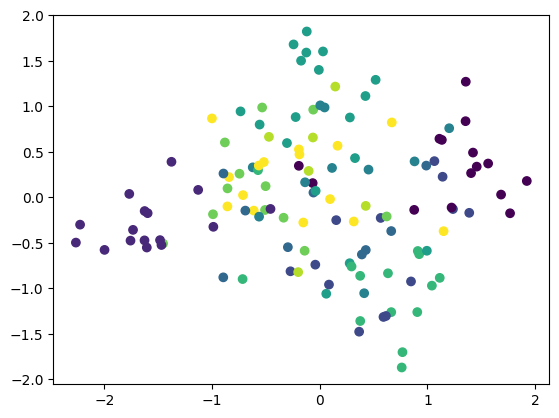

In [29]:
dr = PCA(2)

plt.scatter(*dr.fit_transform(z.detach().cpu().numpy()).T, c=y)

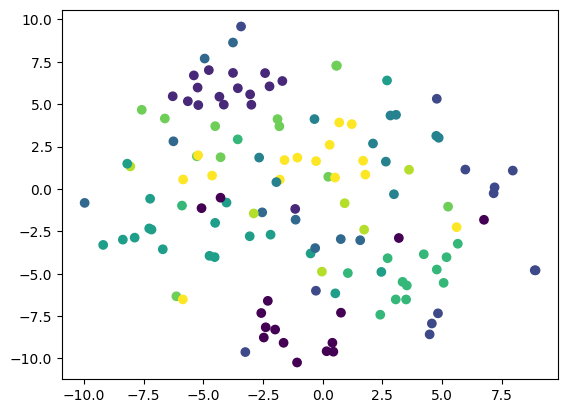

In [30]:
dr = TSNE(2)

plt.scatter(*dr.fit_transform(z.detach().cpu().numpy()).T, c=y)

In [31]:
from torchlake.common.controller.weight_manager import WeightManager

weight_manager = WeightManager(artifact_path.joinpath('dae.pth').as_posix())

In [32]:
model_path = weight_manager.get_filename()
model_path

WindowsPath('../../artifacts/dae/dae.pth')

In [33]:
weight_manager.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\dae\dae.pth, model size is 1.01MiB


In [34]:
weight_manager.load_weight(model_path, model)